In [1]:
import numpy as np 
import sys
sys.path.append("../")
import pickle as pkl
import os
from pathlib import Path
import fnmatch

from glob import glob
import search_world
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.special import kl_div

In [8]:
fns_dict = get_data_paths()
vector_fns = fns_dict['vector_fns']
scalar_fns = fns_dict['scalar_fns']


vector_fns = vector_fns
scalar_fns = scalar_fns
# df = get_trials_dataframe(vector_fns=vector_fns, scalar_fns=scalar_fns)
df = get_trials_features(df)
df = df[df.agent_dist < 99]

# Distribution of conditions across agents

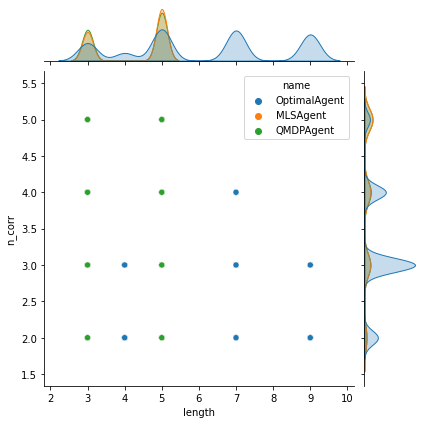

In [10]:
sns.jointplot(data=df, x='length', y='n_corr', hue='name')

In [12]:
def get_data_paths(job_id=''):    
    """Returns list of scalar/vector data filenames, config filenames for a given job_id. If job_id is not specified, will return 
    all config/vector/scalar files in the logs directory. These are sorted such that correspondig scalar/vector/config
    filenames have the same index
    """
    job_id = ''
    data_dir = os.path.join('../logs/', job_id)
    config_fns = [fname for root, _, _ in os.walk(data_dir) for fname in glob(os.path.join(root, 'config.log'))]
    scalar_fns = [fname for root, _, _ in os.walk(data_dir) for fname in glob(os.path.join(root, 'scalar'))]
    vector_fns = [fname for root, _, _ in os.walk(data_dir) for fname in glob(os.path.join(root, 'vector'))]
    vector_fns.sort()
    scalar_fns.sort()
    config_fns.sort()
    return dict(
        scalar_fns=scalar_fns,
        vector_fns=vector_fns,
        config_fns=config_fns
    )

def _flatten_dict(d):
    """Flattens any nested dictionaries in dictionary d into a single-level dictionary. Only flattens a single level"""
    d_copy = {}
    t = {}
    for k, v in d.items():
        if isinstance(v, dict):
            for nested_k, nested_v in v.items():        
                d_copy.update({nested_k: nested_v})
        else:
            d_copy.update({k: v})      
    return d_copy

def get_trials_dataframe(vector_fns, scalar_fns):
    """Aggregates data for a particular job or set of jobs into a single dataframe, where each row corresponds to a trial"""
    # NOTE: This method is and should generally be task-specific, since the way we break up steps into trials should also be trial-specific
    vector_dfs = []
    scalar_dicts = []
    for dataset_index, (vector_fn, scalar_fn) in enumerate(zip(vector_fns, scalar_fns)):
        with open(scalar_fn, 'rb') as f:
            scalar_dict = pkl.load(f) # this dict will likely contain the output of the info methods for both the model and the environment for a particular task, 
            # but the exact content depends on the script being used to run the simulations
            scalar_dict.update({'dataset_index': dataset_index})
        # TODO: Remove following lines. Should be done in trainer.py 
#         scalar_dict.update(scalar_dict['env']._maze_gen_func_kwargs)
        scalar_dict.update(scalar_dict['env'])
        scalar_dict.update(scalar_dict['model'])
        scalar_dicts.append(scalar_dict)
        with open(vector_fn, 'rb') as f:
            vector_dicts = pkl.load(f)
            for d in vector_dicts:
                d = _flatten_dict(d)
            df = pd.DataFrame(vector_dicts)
            df['dataset_index'] = dataset_index
            df['fn'] = vector_fn
            # this is task-specific, but for most tasks will likely work in this manner - finding the timestep at which done is set to True
            df['trial_index'] = df.done.cumsum().shift(fill_value=0)


            # changes are columns to collapse (values should change during a trial)
            # constants are columns that stay the same during a trial
            constants = ['job_id', 'trial_index', 'dataset_index', 'fn']            
            changes = df.columns.difference(constants).tolist()

            f = lambda x: x.tolist() if len(x) > 1 else x

            # flattening dataframe into trial rows
            df = df.groupby(constants)[changes].agg(f).reset_index()

            # makes done value a list (convenient for removing trials that never ended)
            df['done'] = df.done.apply(lambda x: [x] if isinstance(x, bool) else x)

            # removing trials that never ended
            df = df[df.apply(lambda x: True in x.done, axis=1)].reset_index()

            vector_dfs.append(df)

    scalar_df = pd.DataFrame(scalar_dicts)
    
    df = pd.concat(vector_dfs).reset_index()
    
    df = df.merge(scalar_df, on='dataset_index')
    
    return df     

def get_trials_features(df):
    """Given a dataframe of trials, returns updated trials with new features extracted from raw data. TASK SPECIFIC"""
    df = df.copy()
    df['agent_dist'] = df.apply(lambda x: len(x.action) - 1, axis=1)
#     df['agent_err'] = df.apply(lambda r: get_agent_err(r, df), axis=1)
    
#     df['agent_error'] = 1 - df.min_dist/df.agent_dist
    return df

def get_consistency(df, condition, group_1_func, group_2_func, metric, suffixes):
#     suffixes_1 = [suffixes[0] + '_split_1', suffixes[0] + '_split_2']
#     suffixes_2 = [suffixes[1] + '_split_1', suffixes[1] + '_split_2']
#     group_1_consistency_dict = get_self_consistency(df=df, condition=condition, group_func=group_1_func, metric=metric, suffixes=suffixes_1)
#     group_2_consistency_dict = get_self_consistency(df=df, condition=condition, group_func=group_2_func, metric=metric, suffixes=suffixes_2)
#     df = df.copy()
#     df1 = df[df.apply(group_1_func, axis=1)]
#     df2 = df[df.apply(group_2_func, axis=1)]
#     condition_metric_df1 = df1.groupby(condition)[metric].mean().to_frame()
#     condition_metric_df2 = df2.groupby(condition)[metric].mean().to_frame()
#     merged = condition_metric_df1.merge(condition_metric_df2, on=condition, suffixes=suffixes)
#     cross_corr = merged[metric + suffixes[0]].corr(merged[metric + suffixes[1]])
#     cross_corr = cross_corr / np.sqrt(np.mean(group_1_consistency_dict['corr']) * np.mean(group_2_consistency_dict['corr']))
#     return dict(
#         group_1_consistency_dict=group_1_consistency_dict,
#         group_2_consistency_dict=group_2_consistency_dict,
#         corr=cross_corr,
#         df=merged        
#     )
    m = df.groupby(['length', 'n_corr', 'target_pos', 'agent_init_pos', 'name'])['agent_dist'].agg(lambda r: [np.histogram(list(r.values), bins=bins, density=True)[0]]).to_frame()
    m = m.reset_index()
    subopt = m[m['name'] != 'OptimalAgent']
    opt = m[m['name'] == 'OptimalAgent']
    merged = subopt.merge(opt, on=condition, suffixes=('_subopt','_opt'))
def mask(n, p=0.5):
    a = np.zeros(n, dtype=int)
    a[:int(p * n)] = 1
    np.random.shuffle(a)
    a = a.astype(bool)
    return a

def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a*b != 0, a * np.log(a/b), 0))

def euclid_dist(a, b):
    return np.linalg.norm(a - b)



def get_self_consistency(df, condition, group_func, metric, suffixes, num_iterations=1):
    df = df.copy()
    bins = np.arange(df[metric].min()-1, df[metric].max()+1)
    opt_df = df[df['name'] == 'OptimalAgent']
    opt_df = opt_df.groupby(condition)[metric].agg(lambda r: [np.histogram(list(r.values), bins=bins, density=True)[0]]).to_frame()    
    df = df[df.apply(group_func, axis=1)]
    df = df.set_index(condition) 

    grouped_df = df.groupby(condition)
    corrs = []
    for i in range(num_iterations):
        masks = grouped_df.index.agg('count').agg(lambda x: mask(x)).to_frame()
        df1 = grouped_df.apply(lambda x: x[masks.loc[x.index[0]][0]])
        df2 = grouped_df.apply(lambda x: x[~masks.loc[x.index[0]][0]])
        opt_metric_df = opt_df.groupby(condition)[metric].agg(lambda r: [np.histogram(list(r.values), bins=bins, density=True)[0]]).to_frame()
        condition_metric_df1 = df1.groupby(condition)[metric].agg(lambda r: [np.histogram(list(r.values), bins=bins, density=True)[0]]).to_frame()
        condition_metric_df2 = df2.groupby(condition)[metric].agg(lambda r: [np.histogram(list(r.values), bins=bins, density=True)[0]]).to_frame() 
        merged = condition_metric_df1.merge(condition_metric_df2, on=condition, suffixes=suffixes)
        merged = merged.merge(opt_df, on=condition, suffixes=['', '_opt'])
        merged['split_1'] = merged.apply(lambda r: euclid_dist(r[metric + suffixes[0]][0], r[metric][0]), axis=1)
        merged['split_2'] = merged.apply(lambda r: euclid_dist(r[metric + suffixes[1]][0], r[metric][0]), axis=1)
        corrs.append(merged['split_1'].corr(merged['split_2']))
    return dict(
        corrs=corrs,
        df=merged        
    )


def plot_scores(consistency_df, metric, suffixes):
    sns.scatterplot(data=consistency_df, x=metric+suffixes[0], y=metric+suffixes[1])    
    
def plot_consistency(consistency_arr):
    sns.histplot(consistency_arr)
    

   

In [29]:
group_1_func = mls_func
group_2_func = qmdp_func
metric='agent_dist'
bins = np.arange(df[metric].min()-1, df[metric].max()+1)
suffixes = ['_mls', '_qmdp']
condition = ['length', 'n_corr', 'agent_init_pos', 'target_pos']
name_condition = condition.copy()
name_condition.append('name')
m = df.groupby(name_condition)['agent_dist'].agg(lambda r: [np.histogram(list(r.values), bins=bins, density=True)[0]]).to_frame()
m = m.reset_index()
subopt = m[m['name'] != 'OptimalAgent']
opt = m[m['name'] == 'OptimalAgent']
merged = subopt.merge(opt, on=condition, suffixes=('','_opt'))
kl_divs = merged.apply(lambda r: euclid_dist(r[metric][0], r[metric + '_opt'][0]), axis=1)
df1 = merged[merged.apply(group_1_func, axis=1)].copy()
df2 = merged[merged.apply(group_2_func, axis=1)].copy()
df1['dist'] = df1.apply(lambda r: euclid_dist(r[metric][0], r[metric + '_opt'][0]), axis=1)
df2['dist'] = df2.apply(lambda r: euclid_dist(r[metric][0], r[metric + '_opt'][0]), axis=1)
df1['kl_div'] = df1.apply(lambda r: KL(r[metric][0], r[metric + '_opt'][0]), axis=1)
df2['kl_div'] = df2.apply(lambda r: KL(r[metric][0], r[metric + '_opt'][0]), axis=1)
merged = df1.merge(df2, on=condition, suffixes=suffixes)

/home/apiccato/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in true_divide
/home/apiccato/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in true_divide
/home/apiccato/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in log
/home/apiccato/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in multiply


In [37]:
merged.columns

Index(['length', 'n_corr', 'agent_init_pos', 'target_pos', 'name_mls',
       'agent_dist_mls', 'name_opt_mls', 'agent_dist_opt_mls', 'dist_mls',
       'kl_div_mls', 'name_qmdp', 'agent_dist_qmdp', 'name_opt_qmdp',
       'agent_dist_opt_qmdp', 'dist_qmdp', 'kl_div_qmdp'],
      dtype='object')

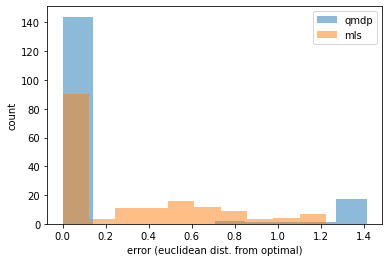

In [39]:
plt.hist(merged['dist_qmdp'], label='qmdp', alpha=0.5)
plt.hist(merged['dist_mls'], label='mls', alpha=0.5)
plt.xlabel('error (euclidean dist. from optimal)')
plt.ylabel('count')
plt.legend()
plt.show()

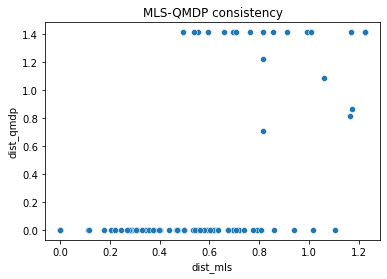

0.6212114973920849


In [40]:
sns.scatterplot(data=merged, x='dist_mls', y='dist_qmdp')
plt.title('MLS-QMDP consistency')
plt.show()
print(merged.dist_mls.corr(merged.dist_qmdp))
plt.show()

## MLS agent consistency

In [13]:
df = df[df.agent_dist < 99]
suffixes = ['_mls_split_1', '_mls_split_2']
def mls_func(x): return x['name'] == 'MLSAgent'
# list of columns whose values define a unique condition
condition = ['length', 'n_corr', 'agent_init_pos', 'target_pos']
mls_consistency_dict = get_self_consistency(df=df, condition=condition, group_func=mls_func,
                                   metric='agent_dist', suffixes=suffixes, num_iterations=10)

0.9182698095203177


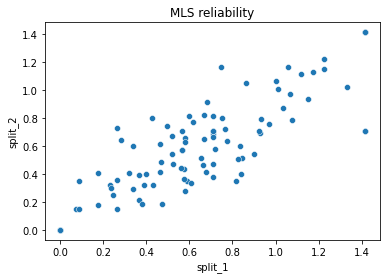

In [17]:
sns.scatterplot(data=mls_consistency_dict['df'], x='split_1', y='split_2')
plt.title('MLS reliability')
print(np.mean(mls_consistency_dict['corrs']))

## QMDP agent consistency

In [18]:
suffixes = ['_qmdp_split_1', '_qmdp_split_2']
def qmdp_func(x): return x['name'] == 'QMDPAgent'
# list of columns whose values define a unique condition
condition = ['length', 'n_corr', 'agent_init_pos', 'target_pos']
qmdp_consistency_dict = get_self_consistency(df=df, condition=condition, group_func=qmdp_func,
                                   metric='agent_dist', suffixes=suffixes, num_iterations=10)

In [22]:
qmdp_consistency_dict['df']

agent_dist_qmdp_split_1  \
length n_corr agent_init_pos target_pos                                                      
3      2      0              3           [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                             6           [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
              3              0           [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                             6           [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
              6              0           [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                                    ...   
5      4      21             6           [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                             9           [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
                             12          [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                             15          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   
                             18          [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   

                                                                   agent_dist_qmdp_split_2  \
length n_corr agent_init_pos target_pos                                                      
3      2      0              3           [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                             6           [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
              3              0           [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                             6           [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
              6              0           [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                                    ...   
5      4      21             6           [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                             9           [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
                             12          [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                             15          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   
                             18          [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   

                                                                                agent_dist  \
length n_corr agent_init_pos target_pos                                                      
3      2      0              3           [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                             6           [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
              3              0           [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                             6           [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
              6              0           [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                                    ...   
5      4      21             6           [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                             9           [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
                             12          [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
                             15          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   
                             18          [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   

                                         split_1  split_2  
length n_corr agent_init_pos target_pos                    
3      2      0              3               0.0      0.0  
                             6               0.0      0.0  
              3              0               0.0      0.0  
                             6               0.0      0.0  
              6              0        

0.9479939784107112


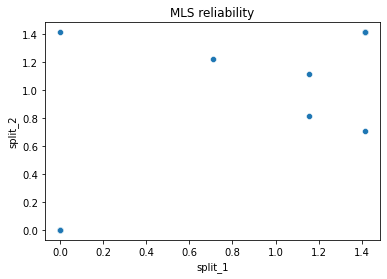

In [20]:
sns.scatterplot(data=qmdp_consistency_dict['df'], x='split_1', y='split_2')
plt.title('MLS reliability')
print(np.mean(qmdp_consistency_dict['corrs']))

## Optimal agent consistency
The optimal agent should have perfect consistency, since its actions are a deterministic function of history.

In [249]:
condition=['length', 'n_corr', 'agent_init_pos', 'target_pos']
df = df[df['agent_dist'] != 99]
opt_consistency_dict = get_self_consistency(df=df, condition=condition, group_func=lambda r: r['name'] == 'OptimalAgent',
                                   metric='agent_dist', suffixes=['_opt_split_1', '_opt_split_2'], num_iterations=10)


In [28]:
merged

,length,n_corr,agent_init_pos,target_pos,name_mls,agent_dist_mls,name_opt_mls,agent_dist_opt_mls,dist_mls,kl_div_mls,name_qmdp,agent_dist_qmdp,name_opt_qmdp,agent_dist_opt_qmdp,dist_qmdp,kl_div_qmdp
0,3,2,0,3,MLSAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0.000000,QMDPAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,0.0
1,3,2,0,6,MLSAgent,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0.000000,QMDPAgent,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",0.0,0.0
2,3,2,3,0,MLSAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0.000000,QMDPAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,0.0
3,3,2,3,6,MLSAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0.000000,QMDPAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,0.0
4,3,2,6,0,MLSAgent,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0.000000,QMDPAgent,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,5,4,21,6,MLSAgent,"[[0.0, 0.0, 0.0, 0.5714285714285714, 0.0, 0.11...",OptimalAgent,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.496016,-0.319780,QMDPAgent,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,0.0
162,5,4,21,9,MLSAgent,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",0.000000,0.000000,QMDPAgent,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...",0.0,0.0
163,5,4,21,12,MLSAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0.000000,QMDPAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0,0.0
164,5,4,21,15,MLSAgent,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0.000000,0.000000,QMDPAgent,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",OptimalAgent,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0.0,0.0


## All agent consistencies

***

# Agent performance

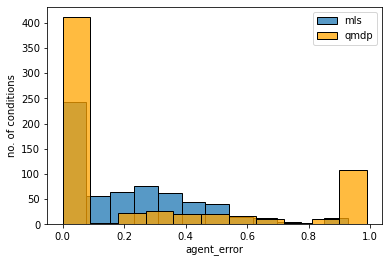

In [167]:
f, ax = plt.subplots(1,1)
mls_score_df = consistency_dict['group_1_consistency_dict']['df'][['agent_error_mls_split_1', 'agent_error_mls_split_2']]
mls_score_df['agent_error'] = mls_score_df.mean(axis=1)
qmdp_score_df = consistency_dict['group_2_consistency_dict']['df'][['agent_error_qmdp_split_1', 'agent_error_qmdp_split_2']]
qmdp_score_df['agent_error'] = qmdp_score_df.mean(axis=1)

sns.histplot(data=mls_score_df, x='agent_error', label='mls',ax=ax)
sns.histplot(data=qmdp_score_df, x='agent_error', label='qmdp',ax=ax,color='orange')
ax.set_ylabel('no. of conditions')
plt.legend()
plt.show()
# sns.lineplot(data=qmdp_score_df, x='length', y='agent_score', estimator='mean', ci="sd", label='qmdp', ax=ax)

In [172]:
df2.groupby(condition)[metric].agg(lambda r: np.histogram(r.values, bins=bins)
mls_score_df['agent_error'].mean()
qmdp_score_df['agent_error'].mean()

0.24910987301517384

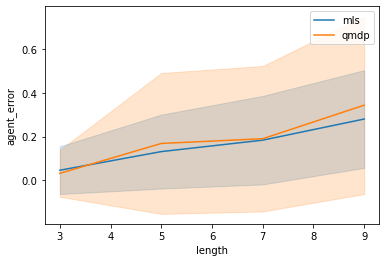

In [168]:
f, ax = plt.subplots(1,1)
# mls_score_df = consistency_dict['group_1_consistency_dict']['df'][['agent_score_mls_split_1', 'agent_score_mls_split_2']]
# mls_score_df['agent_error'] = mls_score_df.mean(axis=1)

sns.lineplot(data=mls_score_df, x='length', y='agent_error', estimator='mean',ci="sd", label='mls', ax=ax)

# qmdp_score_df = consistency_dict['group_2_consistency_dict']['df'][['agent_score_qmdp_split_1', 'agent_score_qmdp_split_2']]
# qmdp_score_df['agent_error'] = qmdp_score_df.mean(axis=1)

sns.lineplot(data=qmdp_score_df, x='length', y='agent_error', estimator='mean', ci="sd", label='qmdp', ax=ax)

plt.show()

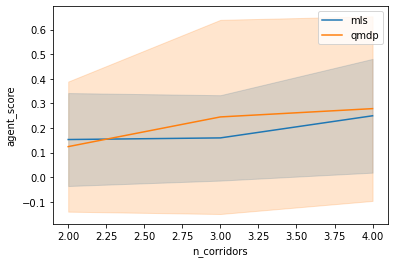

In [138]:
f, ax = plt.subplots(1,1)
mls_score_df = consistency_dict['group_1_consistency_dict']['df'][['agent_score_mls_split_1', 'agent_score_mls_split_2']]
mls_score_df['agent_error'] = mls_score_df.mean(axis=1)

sns.lineplot(data=mls_score_df, x='n_corridors', y='agent_score', estimator='mean',ci="sd", label='mls', ax=ax)

qmdp_score_df = consistency_dict['group_2_consistency_dict']['df'][['agent_score_qmdp_split_1', 'agent_score_qmdp_split_2']]
qmdp_score_df['agent_error'] = qmdp_score_df.mean(axis=1)

sns.lineplot(data=qmdp_score_df, x='n_corridors', y='agent_score', estimator='mean', ci="sd", label='qmdp', ax=ax)

plt.show()

# Cross-agent consistency scores

In [173]:
def mls_func(x): return x['name'] == 'MLSAgent'
def qmdp_func(x): return x['name'] == 'QMDPAgent'
suffixes = ['_mls', '_qmdp']
# list of columns whose values define a unique condition
condition = ['length', 'n_corridors', 'agent_initial_position', 'target_position']
corrs = []
for i in range(10):
    consistency_dict = get_consistency(df=df, condition=condition, group_1_func=mls_func, group_2_func=qmdp_func,
                                       metric='agent_error', suffixes=suffixes)
    corrs.append(consistency_dict['corr'])


MLS-QMDP consistency: 0.70


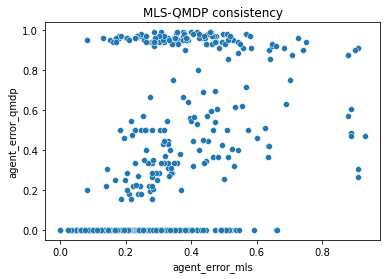

In [163]:
print('MLS-QMDP consistency: %.2f' % consistency_dict['corr'])
plot_scores(consistency_df=consistency_dict['df'], metric='agent_error', suffixes=suffixes)
plt.title('MLS-QMDP consistency')
plt.show()

# OLD

In [25]:
# TODO: Find number of trials per condition
# TODO: Find agent score on each trial 
df = all_df[all_df['name'] == 'MLSAgent']
condition = ['length', 'n_corridors', 'agent_initial_position', 'target_position']
print(df.columns)
df = df.set_index(condition) # grouping by initial condition and maze configuratio
# TODO: Splitting dataframe into two datasets per condition
grouped_df = df.groupby(condition)
def mask(n, p=0.5):
    a = np.zeros(n, dtype=int)
    a[:int(p * n)] = 1
    np.random.shuffle(a)
    a = a.astype(bool)
    return a
masks = grouped_df.index.agg('count').agg(lambda x: mask(x)).to_frame()
df1 = grouped_df.apply(lambda x: x[masks.loc[x.index[0]][0]])
df2 = grouped_df.apply(lambda x: x[~masks.loc[x.index[0]][0]])
# TODO: Average scores across trials with the same condition
condition_scores_df1 = df1.groupby(['length', 'n_corridors', 'agent_initial_position', 'target_position']).agent_score.mean().to_frame()
condition_scores_df2 = df2.groupby(['length', 'n_corridors', 'agent_initial_position', 'target_position']).agent_score.mean().to_frame()
# TODO: Repeat this to do multi-step cross validation
# TODO: Compare average scores across trials of different agents
merged = condition_scores_df1.merge(condition_scores_df2, on=['length', 'n_corridors', 'agent_initial_position', 'target_position'])
print('MLS correlation: %.2f' % merged.agent_score_x.corr(merged.agent_score_y))
mls_corr = merged.agent_score_x.corr(merged.agent_score_y)

Index(['level_0', 'index', 'job_id', 'trial_index', 'dataset_index', 'action',
       'done', 'info', 'obs', 'reward', 'step', 'env', 'model', 'min_dist',
       'max_dist', 'name', 'horizon', 'lambda', 'agent_dist', 'agent_score'],
      dtype='object')


KeyError: "None of ['length', 'n_corridors', 'agent_initial_position', 'target_position'] are in the columns"

In [252]:
# TODO: Find number of trials per condition
# TODO: Find agent score on each trial 
df = all_df[all_df.name == 'QMDPAgent']
condition = ['length', 'n_corridors', 'agent_initial_position', 'target_position']
df = df.set_index(condition) # grouping by initial condition and maze configuratio
# TODO: Splitting dataframe into two datasets per condition
grouped_df = df.groupby(condition)
def mask(n, p=0.5):
    a = np.zeros(n, dtype=int)
    a[:int(p * n)] = 1
    np.random.shuffle(a)
    a = a.astype(bool)
    return a
masks = grouped_df.index.agg('count').agg(lambda x: mask(x)).to_frame()
df1 = grouped_df.apply(lambda x: x[masks.loc[x.index[0]][0]])
df2 = grouped_df.apply(lambda x: x[~masks.loc[x.index[0]][0]])
# TODO: Average scores across trials with the same condition
condition_scores_df1 = df1.groupby(['length', 'n_corridors', 'agent_initial_position', 'target_position']).agent_score.mean().to_frame()
condition_scores_df2 = df2.groupby(['length', 'n_corridors', 'agent_initial_position', 'target_position']).agent_score.mean().to_frame()
# TODO: Repeat this to do multi-step cross validation
# TODO: Compare average scores across trials of different agents
merged = condition_scores_df1.merge(condition_scores_df2, on=['length', 'n_corridors', 'agent_initial_position', 'target_position'])
print('QMDP correlation: %.2f' % merged.agent_score_x.corr(merged.agent_score_y))
qmdp_corr = merged.agent_score_x.corr(merged.agent_score_y)

QMDP correlation: 0.97


In [20]:
# Finding cross agent correlation
# TODO: Find number of trials per condition
# TODO: Find agent score on each trial 
condition = ['length', 'n_corridors', 'agent_initial_position', 'target_position']
df = df.set_index(condition) # grouping by initial condition and maze configuration
# TODO: Splitting dataframe into two datasets per condition
df_mls = df[df.name == 'MLSAgent']
df_qmdp = df[df.name == 'QMDPAgent']

condition_scores_df_mls = df_mls.groupby(['length', 'n_corridors', 'agent_initial_position', 'target_position']).agent_score.mean().to_frame()
condition_scores_df_qmdp = df_qmdp.groupby(['length', 'n_corridors', 'agent_initial_position', 'target_position']).agent_score.mean().to_frame()
# TODO: Repeat this to do multi-step cross validation
# TODO: Compare average scores across trials of different agents
merged = condition_scores_df_mls.merge(condition_scores_df_qmdp, on=['length', 'n_corridors', 'agent_initial_position', 'target_position'], suffixes=('_mls', '_qmdp'))

cross_corr = merged.agent_score_mls.corr(merged.agent_score_qmdp)
print('Cross-agent correlation: %.2f' % (cross_corr/(np.sqrt(qmdp_corr * mls_corr))))

NameError: name 'qmdp_corr' is not defined

<AxesSubplot:xlabel='agent_score_mls', ylabel='agent_score_qmdp'>

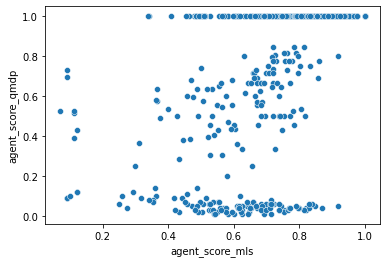

In [257]:
sns.scatterplot(x='agent_score_mls', y='agent_score_qmdp', data=merged)

Seeing for which conditions the agent scores differ the most

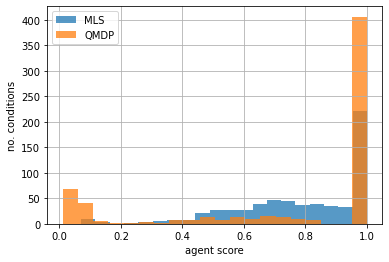

In [258]:
merged.agent_score_mls.hist(label='MLS', alpha=0.75, bins=20)
merged.agent_score_qmdp.hist(label='QMDP', alpha=0.75, bins=20)
plt.legend()
plt.ylabel('no. conditions')
plt.xlabel('agent score')
plt.show()

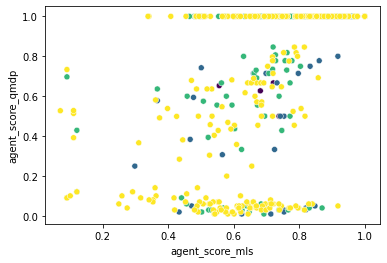

In [259]:
sns.scatterplot(x='agent_score_mls', y='agent_score_qmdp', c=merged.reset_index().length, data=merged, legend=True)
plt.show()

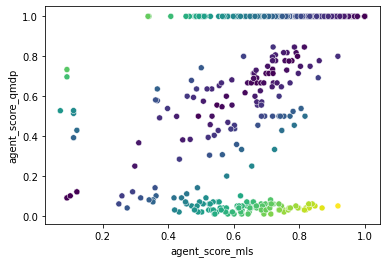

In [261]:
sns.scatterplot(x='agent_score_mls', y='agent_score_qmdp', c=merged.score_diff, data=merged, legend=True, cmap='viridis')
plt.show()

In [260]:
merged['score_diff'] = np.abs(merged.agent_score_qmdp/merged.agent_score_qmdp.max() - merged.agent_score_mls/merged.agent_score_mls.max())
merged['score_diff'] = merged['score_diff']/merged['score_diff'].max()

In [201]:
print(merged.score_diff.corr(merged['length']))
print(merged.score_diff.corr(merged['n_corridors']))

0.28866877345182745
0.06927391857489822


In [ ]:
## SCRATCH: When is the distance 99? Try replicating this## 
from search_world.envs.maze import MazeStateSpace, MazeActionSpace, MazeObservationSpace
r = df[df['agent_dist'] == 99].iloc[0]
# print(r)
maze = r.maze
state_space = MazeStateSpace(maze)
action_space = MazeActionSpace()
def _observation_func(coor) -> object:
    # TODO: Add possibility of informative observations
    """Generates observation for given coordinate position. Useful for constructing entire observation space

    Args:
        state (tuple of ints): coordinates from which to generate observation. 
    """
    target_position = state_space[r['target_pos']]
    adjacent_nodes = np.asarray([[0, 1], [1, 0], [0, -1], [-1, 0]]) + coor
    adjacent_nodes = tuple([maze[node_x, node_y] for (node_x, node_y) in adjacent_nodes])
    # is_inf = np.any(np.all(np.isin(self._inf_positions, coor, True), axis=1))
    is_target = np.all(coor == target_position)
    return adjacent_nodes + (is_target, )
obs_space = MazeObservationSpace(state_space, _observation_func)
print(state_space[r['target_pos']])
print(state_space[r['agent_init_pos']])
for a, o in zip(r['action'][1:], r['obs'][1:]): 
    print(action_space[a])
    print(obs_space[o])
## SCRATCH